In [240]:
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw
from PIL.ImageOps import grayscale

mask_data = pd.read_json("zurich/segmented/zurich_000000_000019_gtFine_polygons.json")
masked_img = Image.open("zurich/segmented/zurich_000000_000019_gtFine_color.png")
masked_img_label = Image.open("zurich/segmented/zurich_000000_000019_gtFine_labelIds.png")

img = Image.open("zurich/annotat/zurich_000000_000019_leftImg8bit.png")

In [231]:
categories = pd.Series([m['label'] for m in mask_data['objects']])

In [232]:
categories.unique()

array(['static', 'sky', 'building', 'vegetation', 'ground', 'road',
       'sidewalk', 'fence', 'pole', 'traffic light', 'traffic sign',
       'train', 'person', 'car', 'cargroup', 'dynamic', 'ego vehicle',
       'out of roi'], dtype=object)

In [233]:
import numpy as np
img_numpy = np.array(img)
img_numpy.dtype

dtype('uint8')

## Visulation avec les polygones

In [234]:
mask = np.array(mask_data['objects'][38]['polygon'])

In [250]:
img_draw = ImageDraw.Draw(img)
img_draw.polygon([tuple(p) for p in mask], outline="red", fill="red")
img.show()

## Retrouver les catégories à partir des labels de l'image

In [251]:
labels = np.array(masked_img_label)

In [282]:
np.unique(labels)

array([ 0,  1,  3,  4,  5,  6,  7,  8, 11, 13, 17, 19, 20, 21, 23, 24, 26,
       31], dtype=uint8)

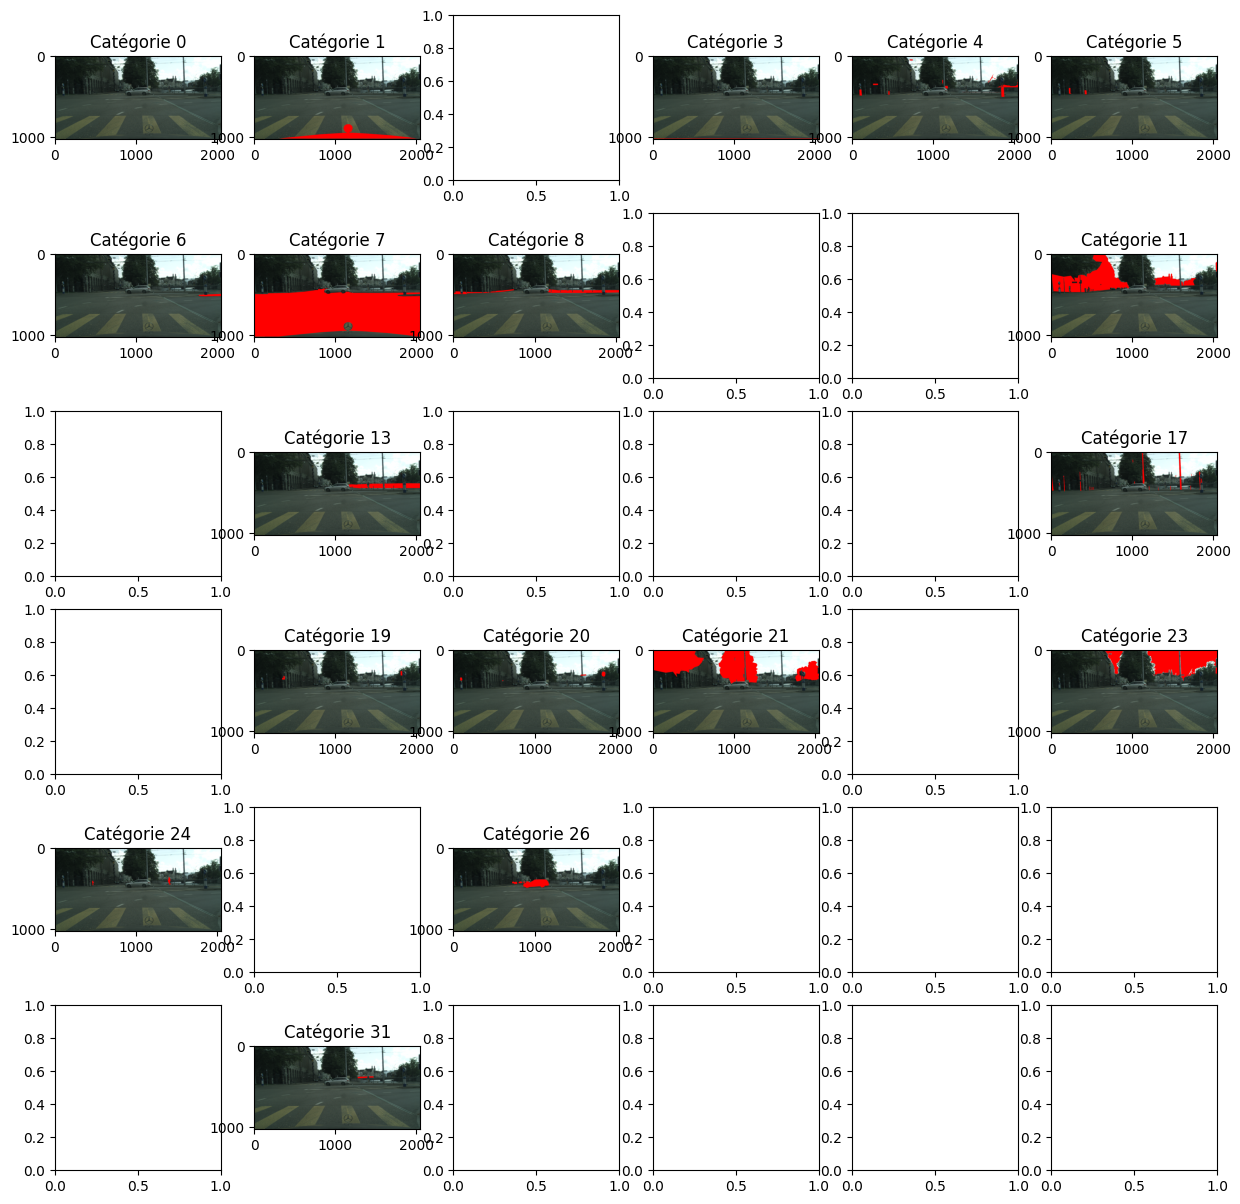

In [280]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(6,6, figsize=(15, 15))
for c in np.unique(labels):
    img_ = img_numpy.copy()
    img_[np.where(labels == c)] = [255, 0, 0]
    ax[c//6, c%6].imshow(Image.fromarray(img_))
    ax[c//6, c%6].title.set_text("Catégorie {}".format(c))
plt.show()

### On va travailler pixel à pixel pour prédire les masks
#### Dans les images labelids, on retrouve chaqu'une des 30 catégories associées à un numéro. On regroupe ces catégories en 8 : véhicules, personnes, sol, végétation, etc.

## Répartition des classes

In [338]:
import glob
import torch
import numpy as np

masks = [np.array(Image.open(p)) for p in glob.glob("zurich/segmented/*_labelIds.png")]
masks_batch = torch.from_numpy(np.array(masks))

In [408]:
from src import utils
import importlib
importlib.reload(utils)
masks_group_batch = utils.group_mask_v2(masks_batch)

In [409]:
import pandas as pd
s = pd.Series(index=list(CATEGORIES_MASK.keys()))
for index, cat_name in enumerate(CATEGORIES_MASK):
    s.loc[cat_name] = int((masks_group_batch[...,index] == 1).sum())

In [451]:
s

void             19947271.0
flat            101914515.0
construction     55441872.0
object            4716010.0
nature           40733910.0
sky               9628046.0
human             3413751.0
vehicle          20057169.0
dtype: float64

<Axes: >

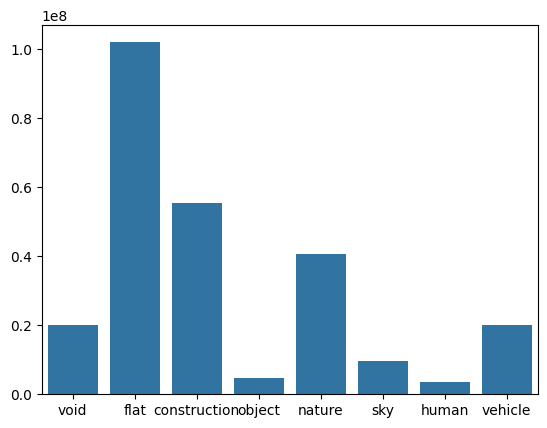

In [410]:
import seaborn as sns
sns.barplot(s)

In [441]:
masks_group_batch_label = utils.group_mask_v2(masks_batch, with_cat_number=True)

In [460]:
masks_concatenate = masks_group_batch_label.view(-1)
masks_concatenate = masks_concatenate.long()
masks_concatenate_clean=masks_concatenate[masks_concatenate>0]

In [462]:
display(masks_concatenate.shape)
masks_concatenate_clean.shape

torch.Size([2046820352])

torch.Size([255852544])

In [468]:
torch.unique(masks_concatenate_clean)

tensor([1, 2, 3, 4, 5, 6, 7, 8])

In [469]:
counts = torch.bincount(masks_concatenate_clean)[1:] # remove 0

In [470]:
frequencies = counts.float() / counts.sum()
class_weights = 1.0 / (frequencies + 1e-6)  # pour éviter la division par zéro
class_weights = class_weights / class_weights.sum()  # normalisation (optionnel)

In [471]:
class_weights

tensor([0.0659, 0.0129, 0.0237, 0.2786, 0.0323, 0.1364, 0.3848, 0.0655])